<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/J-TKim/Gans_in_action/blob/master/Ch4/Ch4_DCGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 코드 4-1 임포트하기
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
# 코드 4-2 모델의 입력 차원
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels) # 입력 이미지 차원
z_dim = 100 # 생성자의 입력으로 사용할 잡음 벡터의 크기

In [3]:
# 코드 4-3 DCGAN 생성자
def build_generator(z_dim):
    
    model = Sequential()
    
    model.add(Dense(256 * 7 * 7, input_dim=z_dim)) # 완전 연결 층을 사용해 입력을 7 x 7 x 256 크기 텐서로 바꾼다.
    model.add(Reshape((7, 7 ,256)))
    
    # 7 x 7 x 256에서 14 x 14 x 128 크기의 텐서로 바꾸는 전치 합성급 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    
    model.add(BatchNormalization()) # 배치 정규화
    
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    
    # 14 x 14 x 128에서 14 x 14 x 64 크기의 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding="same"))
    
    model.add(BatchNormalization()) # 배치 정규화
    
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    
    # 14 x 14 x 64에서 28 x 28 x 1 크기 텐서로 바꾸는 전치 활성화 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same"))
    
    model.add(Activation("tanh")) # tanh 활성화 함수를 사용하는 출력층
    
    return model

In [4]:
# 코드 4-4 DCGAN 판별자
def build_discriminator(z_dim):
    model = Sequential()
    
    # 28 x 28 x 1 텐서에서 14 x 14 x 32 크기 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
              kernel_size=3,
              strides=2,
              input_shape=img_shape,
              padding="same"))
    
    model.add(LeakyReLU(alpha=0.01)) # LeakYReLU 활성화 함수
    
    # 14 x 14 x 32 텐서에서 7 x 7 x 64 크기 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
              kernel_size=3,
              strides=2,
              padding="same"))
    
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    
    # 7 x 7 x 64 텐서에서 3 x 3 x 128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
              kernel_size=3,
              strides=2,
              padding="same"))
    
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    
    model.add(Flatten()) 
    model.add(Dense(1, activation="sigmoid")) # 시그모이드 활성화 함수를 사용하는 출력층
    
    return model

In [5]:
# 코드 4-5 모델 생성과 컴파일
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    # 생성자 + 판별자 모델 연결
    model.add(generator)
    model.add(discriminator)
    
    return model

In [6]:
discriminator = build_discriminator(img_shape) # 판별자 모델 생성
discriminator.compile(loss="binary_crossentropy",
                         optimizer=Adam(),
                         metrics=["acc"])
    
generator = build_generator(z_dim) # 생성자 모델 생성
    
discriminator.trainable = False
    
gan = build_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy", optimizer=Adam())

In [7]:
# 코드 4-6 DCGAN 훈련 반복
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data() # MNIST 데이터셋 로드
    
    X_train = X_train / 127.5 - 1.0 # [0. 255] 흑백 픽셀 값을 [-1, 1]으로 스케일 조정
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones((batch_size, 1)) # 진짜 이미지의 레이블 모두 1
    
    fake = np.zeros((batch_size, 1)) # 가짜 이미지의 레이블 모두 0
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 진짜 이미지의 랜덤 배치 얻기
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 배치 만들기
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real) # 판별자 훈련하기
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, acc = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 배치 만들기
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real) # 생성자 훈련하기
        
        if (iteration + 1) % sample_interval == 0:
            
            # 훈련이 끝난 후에 그래프로 그리이 위해 손실과 정확도를 저장하기
            losses.append((d_loss, g_loss))
            accuracies.append(100 * acc)
            iteration_checkpoints.append(iteration + 1)
            
            # 훈련 진행 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [g 손실: %f]" %
                 (iteration + 1, d_loss, 100 * acc, g_loss))
            
            sample_images(generator) # 생성된 이미지 샘플 출력 

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim)) # 랜덤한 잡음 샘플링

    gen_imgs = generator.predict(z) # 랜덤한 잡음에서 이미지 생성하기

    gen_imgs = 0.5 * gen_imgs + 0.5 # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

1000 [D 손실: 0.471705, 정확도: 78.52%] [g 손실: 1.976178]


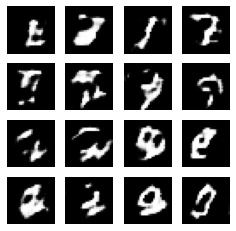

2000 [D 손실: 0.421668, 정확도: 80.08%] [g 손실: 1.332279]


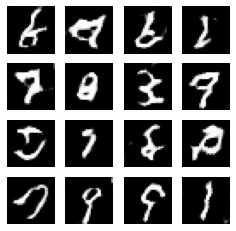

3000 [D 손실: 0.450188, 정확도: 80.08%] [g 손실: 1.673805]


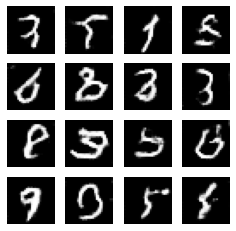

4000 [D 손실: 0.408262, 정확도: 80.47%] [g 손실: 2.070666]


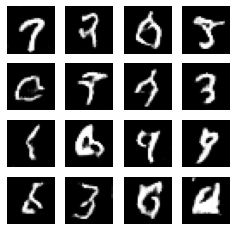

5000 [D 손실: 0.375018, 정확도: 82.03%] [g 손실: 2.178688]


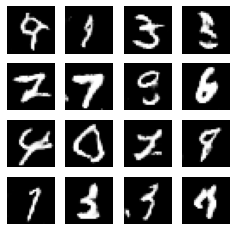

6000 [D 손실: 0.364035, 정확도: 83.98%] [g 손실: 2.161492]


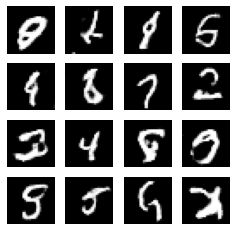

7000 [D 손실: 0.406067, 정확도: 80.08%] [g 손실: 1.982092]


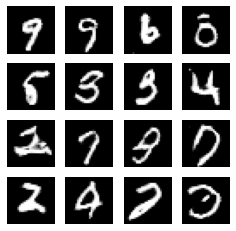

8000 [D 손실: 0.422510, 정확도: 83.59%] [g 손실: 2.070693]


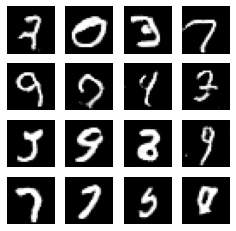

9000 [D 손실: 0.388110, 정확도: 82.03%] [g 손실: 2.207825]


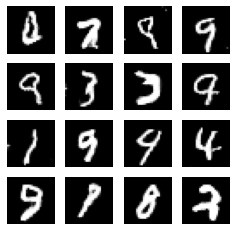

10000 [D 손실: 0.413174, 정확도: 80.47%] [g 손실: 2.185864]


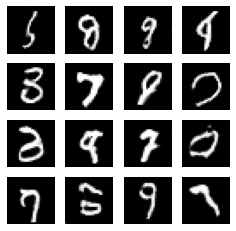

11000 [D 손실: 0.411855, 정확도: 81.25%] [g 손실: 2.020361]


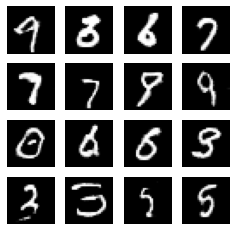

12000 [D 손실: 0.374510, 정확도: 82.03%] [g 손실: 2.001189]


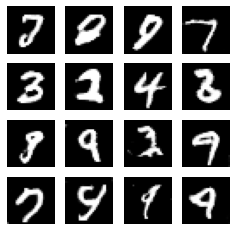

13000 [D 손실: 0.374186, 정확도: 80.86%] [g 손실: 2.195725]


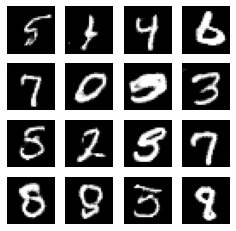

14000 [D 손실: 0.376988, 정확도: 82.03%] [g 손실: 2.154402]


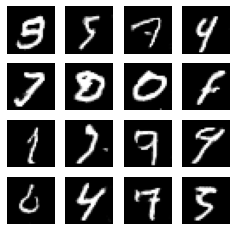

15000 [D 손실: 0.372429, 정확도: 82.42%] [g 손실: 2.145492]


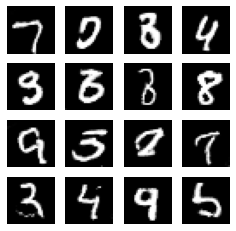

16000 [D 손실: 0.354927, 정확도: 82.03%] [g 손실: 2.005993]


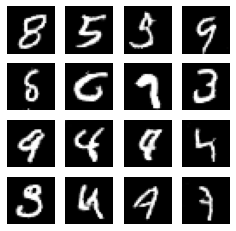

17000 [D 손실: 0.340099, 정확도: 85.94%] [g 손실: 2.195847]


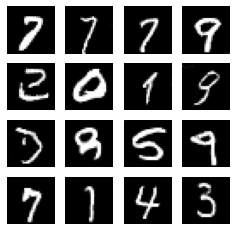

18000 [D 손실: 0.363235, 정확도: 83.98%] [g 손실: 2.200670]


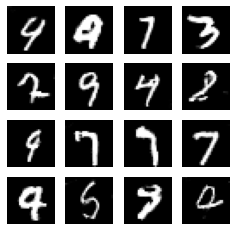

19000 [D 손실: 0.331185, 정확도: 82.42%] [g 손실: 2.060483]


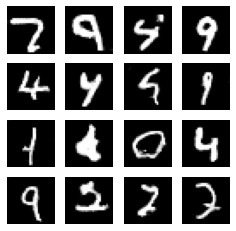

20000 [D 손실: 0.380835, 정확도: 82.03%] [g 손실: 2.258270]


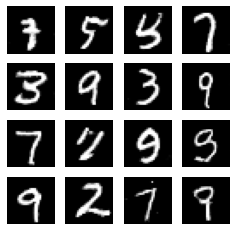

In [9]:
# 코드 4-8 모델 실행

# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

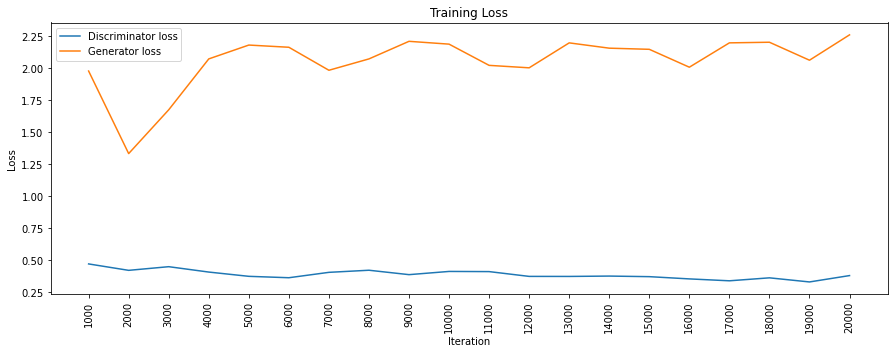

In [10]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

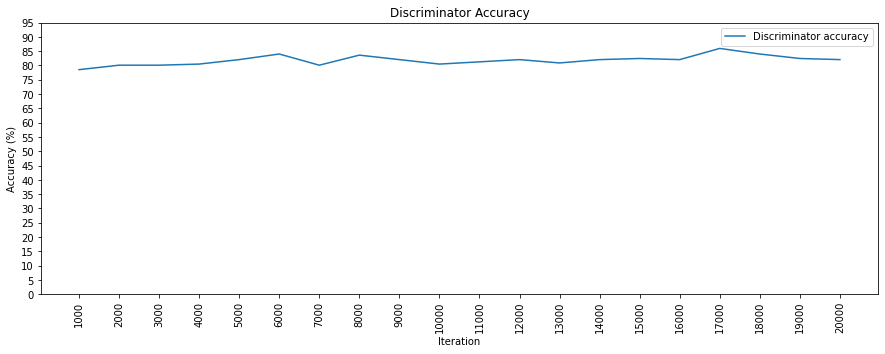

In [11]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()